## **Import libraries**

In [46]:
# 구글 드라이브 어마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
!pip install catboost
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import io
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'NanumGothic' #matplotlib 한글 깨짐 방지

from scipy import stats
from scipy.stats import norm, skew

from category_encoders.ordinal import OrdinalEncoder

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder

from catboost import CatBoostClassifier, Pool

In [49]:
# 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

## **Load Preprocessed Data**

In [80]:
train = pd.read_csv('/content/drive/MyDrive/ESAA 2학기 /프로젝트(1)/데이터/train_1005_4.csv')
test = pd.read_csv('/content/drive/MyDrive/ESAA 2학기 /프로젝트(1)/데이터/test_1005_4.csv')

In [65]:
train.isnull().sum()

gender             0
car                0
reality            0
child_num          0
income_total       0
income_type        0
edu_type           0
family_type        0
house_type         0
work_phone         0
phone              0
email              0
occyp_type         0
begin_month        0
credit             0
YEARS_EMPLOYED     0
MONTHS_EMPLOYED    0
WEEKS_EMPLOYED     0
age                0
per_income         0
age_work           0
income_per_day     0
ID                 0
dtype: int64

In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26453 entries, 0 to 26452
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           26453 non-null  int64  
 1   car              26453 non-null  int64  
 2   reality          26453 non-null  int64  
 3   child_num        26453 non-null  int64  
 4   income_total     26453 non-null  float64
 5   income_type      26453 non-null  int64  
 6   edu_type         26453 non-null  int64  
 7   family_type      26453 non-null  int64  
 8   house_type       26453 non-null  int64  
 9   work_phone       26453 non-null  int64  
 10  phone            26453 non-null  int64  
 11  email            26453 non-null  int64  
 12  occyp_type       26453 non-null  int64  
 13  begin_month      26453 non-null  float64
 14  credit           26453 non-null  float64
 15  YEARS_EMPLOYED   26453 non-null  int64  
 16  MONTHS_EMPLOYED  26453 non-null  float64
 17  WEEKS_EMPLOY

In [81]:
# 학습 데이터셋에서 피처와 타겟 데이터셋 분리
train_x = train.drop('credit', axis=1)
train_y = train['credit']
test_x = test

In [69]:
train_x.ID.value_counts()

2274    35
7423    24
1054    24
8725    21
5079    20
        ..
878      1
3222     1
5584     1
2660     1
3764     1
Name: ID, Length: 8746, dtype: int64

## **모델 학습**


In [82]:
n_est = 2000
seed = 42
n_fold = 14
n_class = 3

In [83]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(train_x, train_y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((train_x.shape[0], n_class))
cat_pred_test = np.zeros((test_x.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = train_x.iloc[train_idx], train_x.iloc[valid_idx], train_y[train_idx], train_y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(test_x) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(train_y, cat_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.115115
0:	learn: 1.0359415	test: 1.0330556	best: 1.0330556 (0)	total: 132ms	remaining: 2m 11s
100:	learn: 0.7087396	test: 0.6401799	best: 0.6400909 (99)	total: 10.5s	remaining: 1m 33s
200:	learn: 0.6902006	test: 0.6374860	best: 0.6374753 (167)	total: 22.5s	remaining: 1m 29s
300:	learn: 0.6755607	test: 0.6389590	best: 0.6372796 (231)	total: 34.5s	remaining: 1m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6372795943
bestIteration = 231

Shrink model to first 232 iterations.
CV Log Loss Score: 0.637280

----------------- Fold 1 -----------------

Learning rate set to 0.115115
0:	learn: 1.0354698	test: 1.0346907	best: 1.0346907 (0)	total: 124ms	remaining: 2m 3s
100:	learn: 0.7050402	test: 0.6775372	best: 0.6775240 (89)	total: 12.3s	remaining: 1m 49s
200:	learn: 0.6867526	test: 0.6763472	best: 0.6761498 (195)	total: 25.2s	remaining: 1m 39s
300:	learn: 0.6692414	test: 0.6767813	best: 0.6759300 (21

### **Feature Importance**

In [88]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

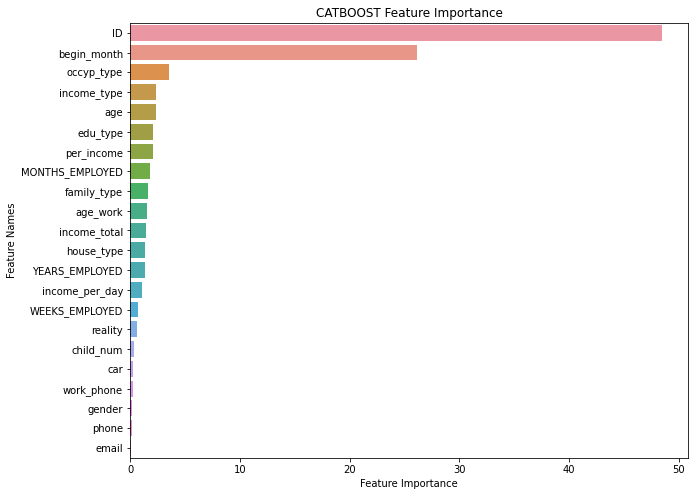

In [89]:
plot_feature_importance(model_cat.get_feature_importance(),test_x.columns,'CATBOOST')

### **학습 곡선**

In [90]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1,1.0,5)):
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel("Training examples")
  plt.ylabel("Score")
  train_sizes, train_scores, test_scores = learning_curve(
      estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
  )
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()

  # 그래프 사이의 공간 색칠
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.1, color='r')
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std, alpha=0.1, color='r')
  plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
           label = "Training score")
  plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
           label = "Cross-validation score")
  plt.legend(loc='best')
  return plt

In [ ]:
g = plot_learning_curve(model_cat,"Catboost learning curves",X_train,y_train, cv=5)

## **최종 제출 파일 생성**

In [84]:
submission = pd.read_csv('/content/drive/MyDrive/ESAA 2학기 /프로젝트(1)/데이터/sample_submission.csv')

In [85]:
submission.loc[:,1:] = cat_pred_test

In [86]:
submission

,index,0,1,2
0,26457,0.184257,0.204713,0.611030
1,26458,0.067609,0.094286,0.838106
2,26459,0.064474,0.096279,0.839247
3,26460,0.046809,0.079619,0.873572
4,26461,0.061656,0.140443,0.797901
...,...,...,...,...
9995,36452,0.038596,0.807166,0.154239
9996,36453,0.069405,0.453475,0.477121
9997,36454,0.047424,0.081223,0.871353
9998,36455,0.054857,0.074477,0.870666


In [87]:
submission.to_csv('my_submission_cat_1005.csv', index=False)